# Синтез изображений. Часть 2. Генеративно-Состязательная Сеть (GAN)

## Переключение версии TensorFlow

In [ ]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

## Загрузка и подготовка датасета MNIST

In [2]:
train_ds, info = tfds.load('lfw', split='train', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/lfw/0.1.0.incomplete5WUC24/lfw-train.tfrecord


  0%|          | 0/13233 [00:00<?, ? examples/s]

Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [3]:
ds_numpy = tfds.as_numpy(train_ds)

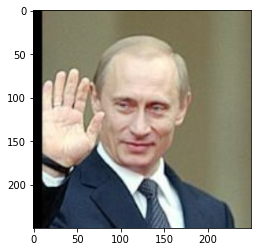

In [51]:
for i in ds_numpy:
    if i[0] == b'Vladimir_Putin':
        plt.imshow(i[1].astype(np.float32) / 255.)

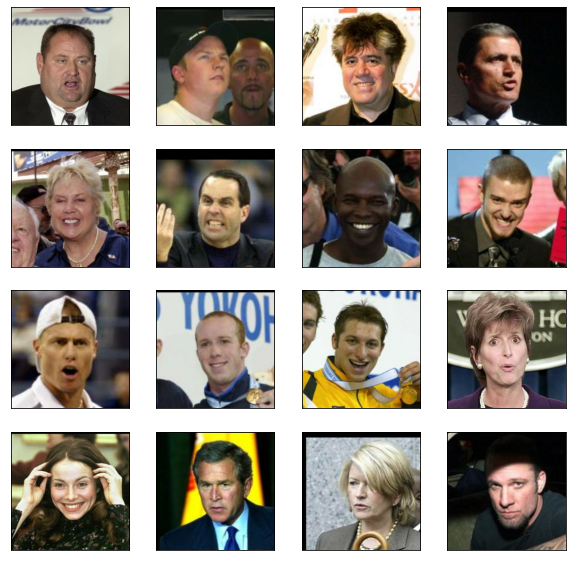

In [4]:
def plot_faces(ds, num):
    fig = plt.figure(figsize=(10, 10))
    for num, i in enumerate(ds, 1):
        if num == 17:
            break
        ax = fig.add_subplot(4, 4, num)
        ax.imshow(i[1].astype(np.float32) / 255.)
        plt.xticks([]), plt.yticks([])
    plt.show()

plot_faces(ds_numpy, 5)

In [6]:
INP_SIZE = 128
EPOCHS = 40
HALF_BATCH_SIZE = 16
BATCH_SIZE = HALF_BATCH_SIZE * 2

def prepare_images(label, img):
    img = tf.cast(img, tf.float32) / 255
    img = tf.image.resize(img, (INP_SIZE, INP_SIZE))
    return img

train_ds = train_ds.shuffle(buffer_size=len(train_ds))
train_ds = train_ds.map(prepare_images)
train_ds = train_ds.repeat(EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

## Deep Convolutional GAN (DCGAN)

In [13]:
momentum = 0.6

generator = tf.keras.Sequential([
    tf.keras.layers.Dense(256*32*32, activation='relu'),
    tf.keras.layers.Reshape((32, 32, 256)),
    tf.keras.layers.UpSampling2D((2, 2)),

    tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=momentum),
    tf.keras.layers.ReLU(),
    tf.keras.layers.UpSampling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=momentum),
    tf.keras.layers.ReLU(),
     
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'), 
    tf.keras.layers.BatchNormalization(momentum=momentum),
    tf.keras.layers.ReLU(),

    tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='tanh')
])

discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),  

    tf.keras.layers.Conv2D(64, kernel_size=5, strides=(2, 2), padding='same'),
    # tf.keras.layers.BatchNormalization(momentum=momentum),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(128, kernel_size=5, strides=(2, 2), padding='same'),
    # tf.keras.layers.BatchNormalization(momentum=momentum),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(256, kernel_size=5, strides=(1, 1), padding='same'),
    # tf.keras.layers.BatchNormalization(momentum=momentum),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

In [14]:
LEARNING_RATE = 0.00019
INPUT_DIM = 100

optimizer = tf.keras.optimizers.RMSprop(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [16]:
def plot_images(samples):
    fig = plt.figure(figsize=(12, 12))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(8, 8, j+1)
        ax.imshow((samples[j] * 255).astype(np.uint8))
        plt.xticks([]), plt.yticks([])
    plt.show()

[Step  0] D Loss: 0.5001; G Loss: 1.1069


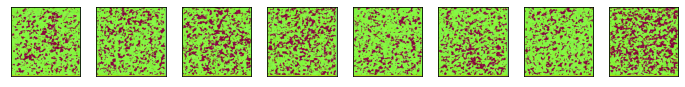

[Step 1000] D Loss: 0.6888; G Loss: 0.7529


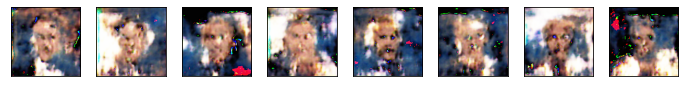

[Step 2000] D Loss: 0.6887; G Loss: 0.7129


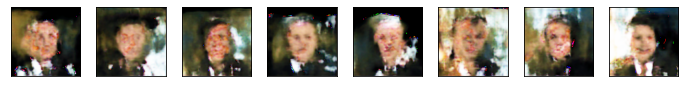

[Step 3000] D Loss: 0.6892; G Loss: 0.8435


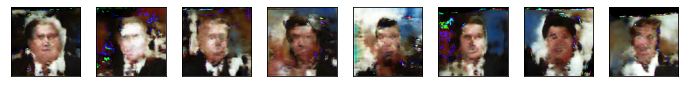

[Step 4000] D Loss: 0.7115; G Loss: 0.9734


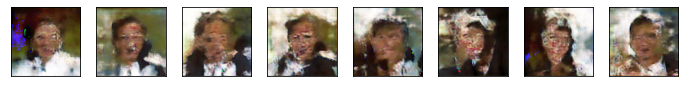

[Step 5000] D Loss: 0.6143; G Loss: 0.6233


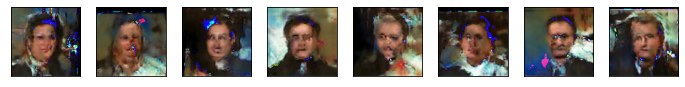

[Step 6000] D Loss: 0.6826; G Loss: 1.2731


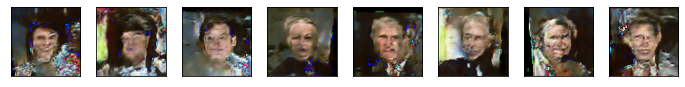

[Step 7000] D Loss: 0.6174; G Loss: 1.3250


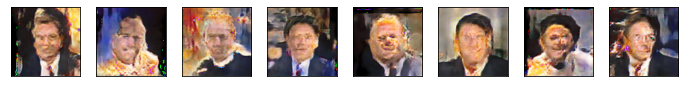

[Step 8000] D Loss: 0.6169; G Loss: 0.5689


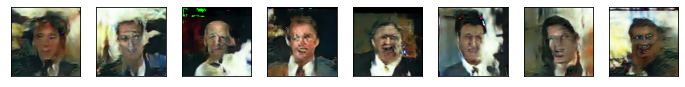

[Step 9000] D Loss: 0.6208; G Loss: 0.6459


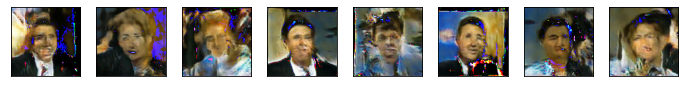

[Step 10000] D Loss: 0.8309; G Loss: 1.1441


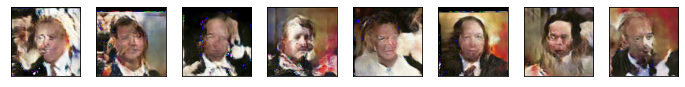

[Step 11000] D Loss: 0.6910; G Loss: 0.6541


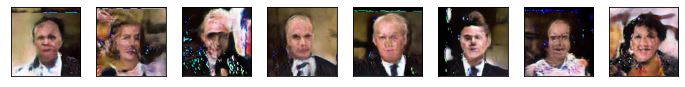

[Step 12000] D Loss: 0.6260; G Loss: 1.2716


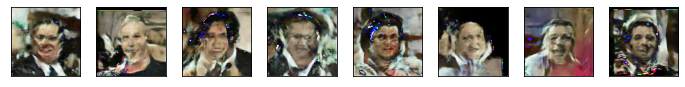

[Step 13000] D Loss: 0.5563; G Loss: 1.1853


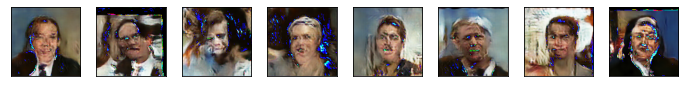

[Step 14000] D Loss: 0.6183; G Loss: 1.0303


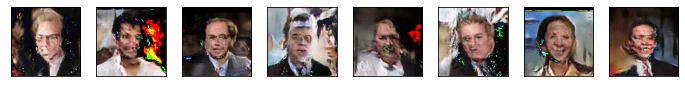

[Step 15000] D Loss: 0.7006; G Loss: 0.6301


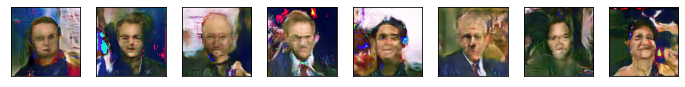

[Step 16000] D Loss: 0.5598; G Loss: 1.0970


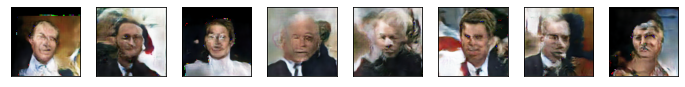

[Step 17000] D Loss: 0.5746; G Loss: 1.0199


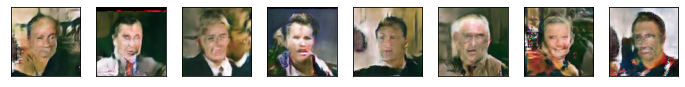

[Step 18000] D Loss: 0.5540; G Loss: 1.0411


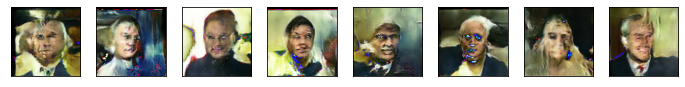

KeyboardInterrupt: ignored

In [17]:
D_losses = []   
G_losses = []

for step, true_images in enumerate(train_ds):
    
    # Train Discriminator
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    D_losses.append(d_loss_value)
    G_losses.append(g_loss_value)

    # Check intermediate results
    if step % 1000 == 0:
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_images(syntetic_images)